# Geopricing with atoti

#dataviz, #simulations, #machine-learning

In this notebook we will create an analytical application to explore retail store pricing and sales data. The sample data in this example has only a few stores and products, but atoti's backend is designed to handle big volumes of data. Please read more about atoti in this article [The key to interactive visualization in Python notebooks](https://www.atoti.io/olap-cubes-the-key-to-interactive-visualization-in-python-notebooks/).

By bringing together the information about sales, prices, competitors and geographical distances, we'll able to **interactively analyse** store margin and it's pricing strategy against competitors. In addition to that, we'll **clusterize the stores** based on the available data - price index and number of nearest competitors - using a machine learning algorithm and inject that information back into the application to identify similar stores. Having found the similar stores, we will use the powerful **simulation** capabilities in atoti to experiment with a store pricing strategy and immidiately visualize the impact on sales margin.

Quick links to the main sections of this notebook:

- [Getting started with data exploration](#start)
- [Enriching sales data with attributes](#enrich_attributes)
- [Interactive price index](#price_index)
- [Nearest competitors count](#grouping)
- [Extracting features](#features)
- [Clusterization using K-means](#cluster)
- [Optimizing prices based on similar competitors](#optimization)
- [Before and After optimization](#before_and_after)
- [Simulating a price reduction](#simulations)

### Imports <a name="imports"></a>

Let's start by importing the libraries required for this notebook to work.

In [1]:
import scipy
import folium
import matplotlib
import seaborn
import atoti as tt
import pandas as pd

Welcome to atoti 0.4.2.20200617181308!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


# Getting started with data exploration <a name="start"></a>

In this section we'll create a basic atoti app to summarize sales margin.

In [2]:
# creating an atoti session
session = tt.create_session()

# loading sales data
productSales = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/outlet_prices.csv",
    keys=["ProductId", "OutletId"],
    store_name="ProductSales",
    types={"ProductId": tt.types.INT, "OutletId": tt.types.INT},
)

productSales.head(3)

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


SellingPrice    Margin
ProductId OutletId                        
4096.0    1.0              1.920  1959.530
          2.0              2.068  2204.228
          3.0              1.820  1835.545

Our data already contains the `Margin` column which is based on quantity, unit price and cost. It’s a good practice to do this kind of fact-level preprocessing outside atoti. Indeed, it avoids redoing these computations on every row over and over, slowing down every query. Like that, atoti only has to do what it’s the best at: aggregation.

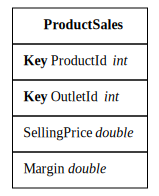

In [3]:
# creating the analytical cube:
cube = session.create_cube(productSales, "PriceIndexCube")

h = cube.hierarchies
m = cube.measures
lvl = cube.levels

# initial simple data model
cube.schema

The above code is anough to start exploring the basic sales summary in atoti app:

In [4]:
session.url

'http://localhost:58676'

In the subsequent sections, we'll enrich the data and add more sophisticated analytics, in addition to the default `.SUM` and `.AVG` aggregation functions.

# Load all data <a name = "load_all"></a>
By default, atoti will load a subset of data to simplify the development and testing. 
Uncomment and run this line to load all data:

In [ ]:
# session.load_all_data()

# Enriching sales data with attributes <a name="enrich_attributes"></a>

In this section we'll load a few extra attributes and link them to the sales datastore, to enable analysis along more dimensions.

In [5]:
# let's load outlet and product attributes into atoti and link them to the sales data
outlets = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/outlets.csv",
    keys=["OutletId"],
    store_name="Outlets",
    types={"OutletId": tt.types.INT},
)

outlets.head(3)

,OutletName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
OutletId,,,,,,,,
1,ActiveViam Outlet Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
2,ActiveViam Outlet Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
3,ActiveViam Outlet Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam


In [6]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/products_info.csv",
    keys=["ProductId"],
    store_name="Products",
)

products.head(3)

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4096,3124480000378,"1,5L CANADA DRY PET",CANADA DRY,1.5,L,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
4097,3124480183927,"1,5L SCHWEPPES LEMON PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4098,3124480183811,2L OASIS ORANGE PET,OASIS,2.0,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC


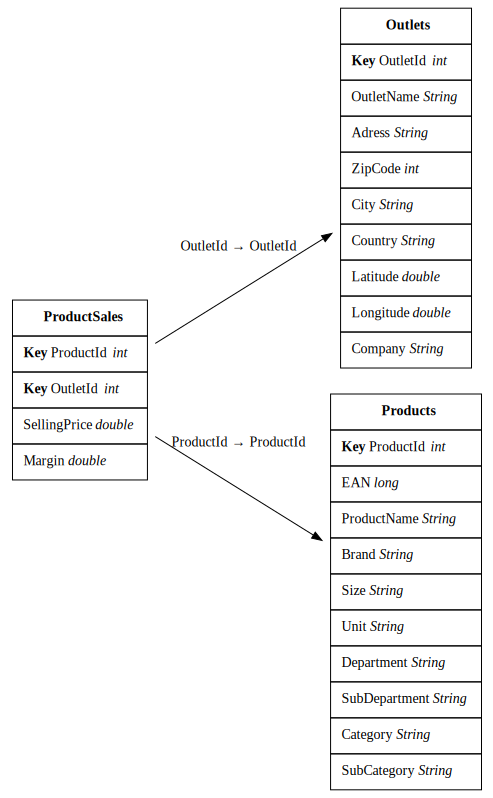

In [7]:
# Linking attributes to sales data
productSales.join(outlets, mapping={"OutletId": "OutletId"})
productSales.join(products, mapping={"ProductId": "ProductId"})
cube.schema

More dimensions became available for analysis and exploration:

In [9]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Interactive price index <a name = "price_index"></a>

In this section we load competitor prices by product and use them to interactively compute the **PriceIndex** for a given outlet on-the-fly.

The `CompetitorPrices` data contains the list of stores that sell the same products. The new datastore will have a many-to-many relationship with our `ProductSales` store as multiple outlets can sell same products.

In [10]:
competitorPrices = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_prices.csv",
    keys=["ProductId", "CompetitorOutletId", "OutletId"],
    store_name="CompetitorPrices"
)

competitorPrices.head(3)

,,,CompetitorPrice
ProductId,CompetitorOutletId,OutletId,
4096.0,101.0,1.0,2.287
4097.0,101.0,1.0,2.320
4098.0,101.0,1.0,2.519


In [12]:
productSales.join(
    competitorPrices, mapping={"ProductId": "ProductId", "OutletId": "OutletId"}
)

Having loaded the competitor prices, we can now define a measure that will interactively compute the **PriceIndex** to see how a retailer **is positioned against one or more of its competitors**. 

The following formula computes an average ratio of outlet price to that of competitors, weighted by sales margin: 

$$PriceIndex = 100 \cdot \frac{\sum_{o,p \in (Outlets,Products)}\frac{Selling Price(o,p)}{Average Competitor Price(o,p)} \cdot Margin(o,p)}{\sum_{o,p \in (Outlets,Products)}Margin(o,p)}$$ 


In [13]:
# The selling price is defined for each OutletId and ProductId, 
# hence we are defining it using `single_value` aggregation function:
m['SellingPrice'] = tt.agg.single_value(productSales["SellingPrice"])

# hiding the MEAN and SUM aggregation functions for price, created automatically by atoti by default:
m['SellingPrice.MEAN'].visible = True
m['SellingPrice.SUM'].visible = True

In [19]:
# Let's use `stop` aggregation function to require "ProductId" attribute for the average price:
m['AverageCompetitorPrice'] = tt.agg.stop(tt.agg.mean(m["CompetitorPrice.VALUE"]), lvl['ProductId'])

For sum up across outlets and products, $\sum_{0,p}$ we set the aggregation scope by `ProductId` and `OutletId`:

In [20]:
price_index_numerator = tt.agg.sum(
    m["SellingPrice"]  / m["AverageCompetitorPrice"]* m["Margin.SUM"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["OutletId"]),
)

m["PriceIndex"] = price_index_numerator / m["Margin.SUM"]

We can now experiment and interactively recompute the **price index** - by playing with the scope competitors. Let's add a few attributes for competitors:

In [21]:
competitorAttributes = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_outlets.csv",
    keys=["CompetitorOutletId"],
    store_name="competitorAttributes",
    types={"CompetitorOutletId": tt.types.INT},
)

competitorPrices.join(
    competitorAttributes, mapping={"CompetitorOutletId": "CompetitorOutletId"}
)

In the following view, we have visualized the `PriceIndex` for one of the outlets. 
We can also break it down or filter, for instance by `CompetitorOutletCity`, and the `PriceIndex` will be reaggregated from data on-the-fly.

In [23]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Distancies to competitors

To assess whether an outlet has strong competition or not, we will count number of competitors 1km, 5km, 10km and 20km away from each outlet. We will use atoti to interactively aggregate the number of stores around an outlet. 

To enrich the outlet information with distances to its nearest competitors, let's use the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula) . Note that another approach would be to use instead something like the [google API to compute distances and durations between two points](https://developers.google.com/maps/documentation/distance-matrix/intro) (thus taking into accounts possible means of transportation).

First we build a matrix containing the distances between outlets and all competitors.

In [24]:
# this utility allows to compute distances using the harvesine formula
from utils import geo_utils
outlets_distances_matrix = geo_utils.create_outlets_distances_matrix(
    pd.read_csv("https://data.atoti.io/notebooks/geopricing/outlets.csv", sep=";"),
    pd.read_csv(
        "https://data.atoti.io/notebooks/geopricing/competitor_outlets.csv", sep=";"
    )
)

outlets_distances_matrix.head(3)

,CompetitorOutletId,OutletId,Competitor distance KM
0,101,1,0.000000
1,101,2,3.145965
2,101,3,2.861697


In [25]:
# loading the distances into the app
distance_matrix = session.read_pandas(
    outlets_distances_matrix,
    keys=["OutletId", "CompetitorOutletId"],
    store_name="DistanceMatrix",
    types={"OutletId": tt.types.INT, "CompetitorOutletId": tt.types.INT,},
)

competitorPrices.join(
    distance_matrix,
    mapping={"CompetitorOutletId": "CompetitorOutletId", "OutletId": "OutletId"},
)

In [ ]:
# cube.schema

## Counting the nearest competitors <a name = "grouping"></a>

In the previous section, we have computed and uploaded distances into atoti. Now let's count the nearest competitors and group them into buckets - within 5 km, 10 km, etc - to quantify the density of competitors for a given outlet.

To be able to easily change the distance we'll create a measure for the distance, and use simulations to override it. This way we'll be able to count competitors for the various distances that we simulated.

The competitors will be counted on the fly, based on the selected scope, so we can perform the analysis interactively.

In [27]:
# Creating a parameter for the distance threshold:
m["Distance in KM"] = 1.0

In [ ]:
# Outlets are linked with Competitors through the same Product that they both sell.
# Hence for each Outlet, there'd need to count distinct Counterparties.


# Hence to count Competitors of a given Store
# We will first fetch the number of different competitors for each product
count_at_product = tt.agg.single_value(
    tt.agg.count_distinct(competitorPrices["CompetitorOutletId"]),
    scope=tt.scope.origin(lvl["ProductId"]),
)

# We can now use the `where` condition to return the number of distinct competitors 
# selling the same products and is located within our threshold radius.
????m["IndicatorWithinDistance"] = tt.agg.single_value(
    tt.where(
        m["Competitor distance KM.VALUE"] < m["Threshold"], count_at_product, 0
    ),
    scope=tt.scope.origin(lvl["ProductId"]),
)

# This measure will display the number of competitors within a range
m["NearestCompetitorsCount"] = tt.agg.sum(
    m["Distance<Thresh"], scope=tt.scope.origin(lvl["CompetitorOutletId"])
)

The `NearestCompetitorsCount` measure allows to recompute the number of competitors based on user query - for the desired outlet and with the desired filters. 

To vizualize the number of competitors based on different distance settings, we'll create a simulation and override the 1.0 km distance we've set above. 

In [29]:
simulation = cube.setup_simulation(
    "Distance Simulation", base_scenario="1 KM", replace=[m["Distance in KM"]]
)
# Setting to sort the scenario labels:
lvl["Distance Simulation"].comparator = tt.comparator.ASC

# Overriding the default value for the distance
simulation.scenarios["5 KM"] = 5.0
simulation.scenarios["10 KM"] = 10.0
simulation.scenarios["15 KM"] = 15.0
simulation.scenarios["20 KM"] = 20.0

Let's do a quick data-viz to see how the number of competitors varies by the distance.

In [ ]:
cube.visualize("Number of competitors stacked by distance bucket")

# Extracting data <a name = "extract"></a>

We want to use the `NearestCompetitorsCount` and `PriceIndex` metrics defined above - to train a model and clusterize the stores. Let's extract the data from atoti.

In [34]:
def get_features():
    
    # this function extracts 
    
    # output dataframe for competitors count per area from cube querying
    outlets_competitors_count_per_area = cube.query(
        m["NearestCompetitorsCount"], levels=[lvl["OutletId"], lvl["Distance Simulation"]],
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    outlets_competitors_count_per_area = outlets_competitors_count_per_area.pivot(
        index="OutletId", columns="Distance Simulation", values="Competitors<Thresh"
    )

    # output dataframe for price index by outlet from cube querying
    price_index_per_outlet = cube.query(
        m["Price Index"], levels=[lvl["OutletId"]]
    ).reset_index()

    # merge the 2 dataframe and return the output
    outlets_features = pd.merge(
        outlets_competitors_count_per_area,
        price_index_per_outlet,
        left_on="OutletId",
        right_on="OutletId",
        how="left",
    ).set_index("OutletId")

    return outlets_features

In [35]:
outlets_features = get_features()
outlets_features.head()

KeyError: 'NearestCompetitorsCount'

## K-Means clusterization <a name="cluster"></a>

In this section we are applying sklearn implementation of the k-means clusterization on the stores based on the features extracted from atoti. The model is trained on the following features - number of nearest competitors and store's Price Index  - and the desired number of clusters is set to 5. 

We will inject the resulting labels back into atoti. We hope that clusterisation will allow us to reveal groups of similar outlets and may help making business decisions around the pricing strategy.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

number_of_clusters = 5
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(outlets_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(outlets_features)]
k_means_labels = pairwise_distances_argmin(outlets_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(outlets_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

In [ ]:
plt.scatter(
    outlets_features.loc[:, "1 KM"],
    outlets_features.loc[:, "Price Index"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [ ]:
outlets_features["Cluster"] = labels
outlets_features.head(5)

In [ ]:
sns.pairplot(data=outlets_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
For example majority of the outlets below to cluster 0, having less than 5 competitors within 1km radius. This cluster generally has index pricing around 1.

Continuing this analysis tells us that:
- Cluster 0 is a small cluster that has slightly lower price index and most competitors are more than 10km away. 
- Cluster 1 is a big cluster with little competitors around.
- Cluster 2 is slight skewed towards a higher price index than the rest while the number of competitors are generally higher even within 5km distance radius.
- Cluster 3 is a small cluster and the number of competitors increases tremendously as the distance radius increases.
- Cluster 4 has a relatively lower price index even though some of the outlets has price index closer to 1. Number of competitors remains about the same across all buckets.

While this gives us an idea of how to position ourselves, we need to put these into context before we can decide on what pricing strategy to apply on it.  
Let's load the new cluster back into the cube to have more in-depth analysis.

## Optimizing prices based on similar competitors <a name = "optimization"></a>

We will now compute new optimized prices using the information about clusters in order to take into account the different competitiveness constraints of the outlets. 

The below optimization algorithm aims to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  

For instance, cluster 0 and cluster 4 have low competition, hence their price index could be slightly higher than 1.  
The rest of the clusters have more competitors within 10km radius, hence could have their price index at 1 or slightly lower to maintain their competitivity. 

In [ ]:
from utils import pricer
selling_prices_based_on_clusters = pricer.optimize_prices(
    pd.read_csv("https://data.atoti.io/notebooks/geopricing/outlets.csv", sep=";"), 
    outlets_features
)

# Optimization: before and after  <a name ="before_and_after"></a>

Using the atoti's built-in simulations capabilities, we can easily upload the new optimized prices and evaluate the impact on the the previously defined KPIs.

In [ ]:
productSales.scenarios["Selling Price Clustering 1"].load_pandas(
    selling_prices_based_on_clusters
)

In [ ]:
price_index_cube.visualize()

Let's load the cluster results obtained from the machine learning model into the cube.

In [ ]:
clusters_df = outlets_features[["Cluster"]].reset_index()
clusters_df.OutletId = clusters_df.OutletId.astype("int32")
clusters = session.read_pandas(clusters_df, keys=["OutletId"], store_name="Clusters")

clusters.head(5)

In [ ]:
outlets.join(clusters)

Let's see the spread of the clusters on the map.

In [ ]:
price_index_cube.visualize("Spread of clusters on map")

Interestingly, cluster 1 is distributed all over France except Paris, and mostly they are the only outlet in the neighbourhood that is under our retailer.  
Cluster 4 is a small cluster around Lille, the capital of the Hauts-de-France region in northern France.
The rest of the clusters have outlets under our retailer in close proximity, and most of them spread around Paris.  
The size of the points on the map reflects the number of competitors within 1km - we can see the competition around the city is the highest. 

In the case of cluster 1, the outlet is the only one under the retailer in the neighbourhood. The number of competitors is low, hence price index is less affected by competition.  
Rather, other factors such as variety of products, branding etc could take on a heavier factor on the price index - these are to be considered when applying a pricing strategy for this cluster. Generally, the price index could be higher.

For the rest of the clusters, there are a few considerations. Within the same proximity, the outlets face the same competitors.  
Not only so, consumers can easily detect the price differences of products between the outlets of the same retailer if they are close by one another.  
Hence it make more sense to align their price index and it should be slightly lower to push up its competitivity.

Now, let's visualize the changes in price index for the 5 clusters.

In [ ]:
price_index_cube.visualize("Price index optimisation difference")

We can see that the pricing method decreased the price index of outlets in clusters that have high competition in order for them to attract more customers.  
On the contrary it increased the prices in outlets belonging to low competition clusters in order to maximize margin.  
Cluster 1 and 4 for instance, have very few competitors. Hence their selling prices are adjusted higher, resulting in higher price index.

### Simulating a price reduction <a name = "simulations"></a>

Zooming in on cluster 2, we see that _ActiveViam Outlet Paris 6_ has one of the highest compeititon within the cluster.  
<img src="https://data.atoti.io/notebooks/geopricing/cluster2.png" alt="Clustering 1" style="width:300px;"/>

However, the store also has a relatively high price index within the cluster.

In [ ]:
price_index_cube.visualize("Price index for cluster 2")

Let's scale down the price index of the outlet using atoti's simulation.

In [ ]:
price_simulation = price_index_cube.setup_simulation(
    "Price simulation",
    base_scenario="Selling Price Initial",
    levels=[lvl["Cluster"], lvl["OutletId"]],
    multiply=[m["SellingPrice.MEAN"]],
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [ ]:
cluster_adjustment = price_simulation.scenarios["Selling Price New"]
cluster_adjustment.append(("2", 7, 0.95),)

In [ ]:
price_index_cube.visualize("Price index optimisation difference by scenario")

The price index after price optimization and the outlet adjustment for the outlet looks more aligned now. 

We saw how machine learning helps to identify the clusters based on the amount geographical competitions.  
With this information, we applied different pricing strategy to each cluster using simulations from atoti to understand the impact on the price index.
We also look within a cluster to adjust the pricing of a specific outlet so that it's more attuned to the pricing of the other outlets in the cluster. 

With atoti, we can easily combine the simulations of various factors such as festivals, promotions, seasons etc.
If we have more data such as the quantity of products sold, we can easily see the differences in the margin with each pricing strategy.  
We can thereafter decide on the best pricing from the combination of simulations.

Do have a look at how we can strategize the price index around product class in the [pricing-simulations-around-product-classes](https://github.com/atoti/notebooks/tree/master/retail/pricing-simulations-around-product-classes) notebook and its [corresponding article](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).  
Maybe you can have a go at combining the two strategies to get your own price index!